In [1]:
#!/usr/bin/env python2
# -*- coding: utf-8 -*-
"""
Created on Fri Mar  2 03:32:51 2018

@author: ks
"""

# setup the matplotlib graphics library and configure it to show figures inline in the notebook
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
np.set_printoptions(threshold=np.inf)

# make qutip available in the rest of the notebook
from qutip import *

In [65]:
def compute(waq_list, wc, wq, g, gac, N, M):
    # Pre-compute operators for the hamiltonian

    a   = tensor(destroy(N), qeye(2), qeye(2)) # destroy of cavity
    sm  = tensor(qeye(N), destroy(2), qeye(2)) # destroy of qubit
    sam = tensor(qeye(N), qeye(2), destroy(2)) # destroy of ancilla

    nq  = tensor(qeye(N), sigmaz(), qeye(2)) # number of qubit
    nc  = tensor(destroy(N).dag() * destroy(N), qeye(2), qeye(2)) # number of cavity
    naq  = tensor(qeye(N), qeye(2), sigmaz()) # number of ancilla
    
    parity_op = -tensor(((0+np.pi*1j)*destroy(N).dag() * destroy(N)).expm(), sigmaz(), sigmaz())
    
    # total parity_oprator
    zero = tensor(basis(N, 0) - basis(N, 0), basis(2,0) - basis(2,0), basis(2, 0) - basis(2, 0))
    
    idx = 0
    err = 0
    evals_posi_mat = np.zeros((len(waq_list), N*2))
    evals_nega_mat = np.zeros((len(waq_list), N*2))
    purity_posi = np.zeros((len(waq_list), N*2))
    purity_nega = np.zeros((len(waq_list), N*2))
    
    for waq in waq_list:    
        tmp_p_list = []
        tmp_m_list = []
        pp_list = []
        pm_list = []
        
        # evaluate the Hamiltonian
        H = 0.5 * (waq - 0.00000001 - M) * naq + 0.5 * wq * nq + wc * nc + g * (a.dag() + a) * (sm + sm.dag()) + gac * (a.dag() + a) * (sam + sam.dag())
      
        # find the energy eigenvalues of the composite system
        evals, ekets = H.eigenstates()       
        
        for i in range(N * 2 * 2):
            pure  = 0
            rho_a = 0
            ei = parity_op * ekets[i] + ekets[i]
            if ei == zero:
                tmp_p_list.append(evals[i])
                rho_a = (ekets[i]*ekets[i].dag()).ptrace(2) 
                pure = rho_a * rho_a
                pp_list.append(pure[1, 1] + pure[0, 0])
            elif ei == 2 * ekets[i]:
                tmp_m_list.append(evals[i])
                rho_a = (ekets[i]*ekets[i].dag()).ptrace(2) 
                pure = rho_a * rho_a
                pm_list.append(pure[1, 1] + pure[0, 0])
            else:
                if ei.norm() < 1.0E-04:
                    tmp_p_list.append(evals[i])
                    rho_a = (ekets[i]*ekets[i].dag()).ptrace(2) 
                    pure = rho_a * rho_a
                    pp_list.append(pure[1, 1] + pure[0, 0])
                else:
                    tmp_m_list.append(evals[i])
                    rho_a = (ekets[i]*ekets[i].dag()).ptrace(2) 
                    pure = rho_a * rho_a
                    pm_list.append(pure[1, 1] + pure[0, 0])
                
        evals_posi = np.asarray(tmp_p_list)
        evals_nega = np.asarray(tmp_m_list)
        purity_p = np.asarray(pp_list)
        purity_n = np.asarray(pm_list)
        
        evals_posi_mat[idx,:] = np.real(evals_posi)
        evals_nega_mat[idx,:] = np.real(evals_nega)
        purity_posi[idx, :] = np.real(purity_p)
        purity_nega[idx, :] = np.real(purity_n)
        
        idx += 1
    return evals_posi_mat, evals_nega_mat, ekets, purity_posi, purity_nega

In [66]:
wc  = 0.8 * 2 * np.pi   # cavity frequency
wq  = 1.0 * 2 * np.pi   # qubit frequency
g   = 0.6 * 2 * np.pi   # cavity-qubit coupling strength
gac = 0.02 * 2 * np.pi  # ancilla-cavity coupling strength
N   = 30
M   = 0.0 * 2 * np.pi
waq_min = 0
waq_max = 2
waq_weg = 1000

waq_list = np.linspace(waq_min, waq_max, waq_weg) * 2.0 * np.pi # ancilla frequency range

evals_posi_mat, evals_nega_mat, ekets, pure_posi, pure_nega = compute(waq_list, wc, wq, g, gac, N, M)

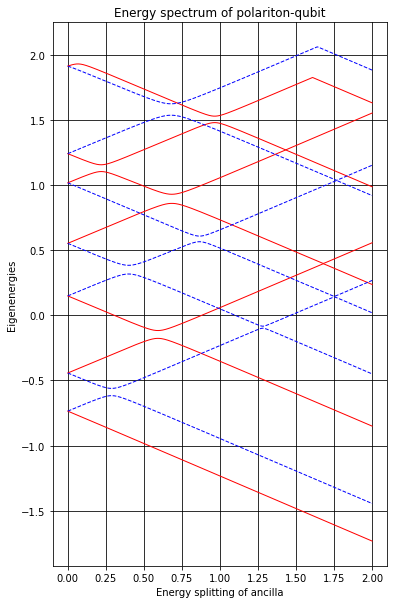

In [88]:
fig, ax = plt.subplots(figsize=(6,10))
snum = 7

for n in range(snum):
    ax.plot((waq_list - M) / (2*np.pi), (evals_posi_mat[:,n]) / (2*np.pi), 'r', linewidth = 1)
    ax.plot((waq_list - M) / (2*np.pi), (evals_nega_mat[:,n]) / (2*np.pi), 'b', linestyle = "dashed", linewidth = 1)
    
ax.set_xlabel('Energy splitting of ancilla')
ax.set_ylabel('Eigenenergies')
ax.set_title( 'Energy spectrum of polariton-qubit')
plt.grid(which='major',color='black',linestyle='-')
plt.grid(which='minor',color='black',linestyle='-');

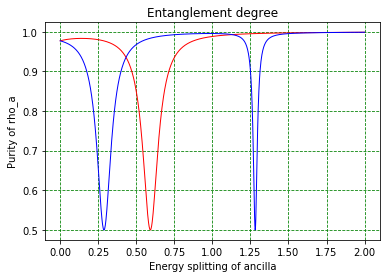

In [67]:
fig, bx = plt.subplots(figsize=(6,4))
snum = 1

bx.plot((waq_list - M) / (2*np.pi), (pure_posi[:,snum]), 'r', linewidth = 1)
bx.plot((waq_list - M) / (2*np.pi), (pure_nega[:,snum]), 'b', linewidth = 1)

bx.set_xlabel('Energy splitting of ancilla')
bx.set_ylabel('Purity of rho_a')
bx.set_title( 'Entanglement degree')
plt.grid(which='major',color='green',linestyle='--')
plt.grid(which='minor',color='blue',linestyle='-');

In [89]:
for i in range(len(waq_list)):
    print(i, pure_nega[i, 1], i/waq_weg*waq_max,i/waq_weg*waq_max * 2 * np.pi)

0 0.9769650717665185 0.0 0.0
1 0.9767552145358529 0.002 0.012566370614359173
2 0.9765401041865345 0.004 0.025132741228718346
3 0.9763196136414897 0.006 0.03769911184307752
4 0.9760936113938573 0.008 0.05026548245743669
5 0.9758619613366865 0.01 0.06283185307179587
6 0.9756245225847785 0.012 0.07539822368615504
7 0.975381149288314 0.014 0.0879645943005142
8 0.9751316904377819 0.016 0.10053096491487339
9 0.9748759896598841 0.018 0.11309733552923254
10 0.9746138850037762 0.02 0.12566370614359174
11 0.9743452087173158 0.022 0.13823007675795088
12 0.9740697870126553 0.024 0.15079644737231007
13 0.9737874398207337 0.026 0.16336281798666924
14 0.9734979805339805 0.028 0.1759291886010284
15 0.9732012157366752 0.03 0.18849555921538758
16 0.9728969449222564 0.032 0.20106192982974677
17 0.9725849601969524 0.034 0.21362830044410594
18 0.9722650459688679 0.036 0.22619467105846508
19 0.971936978621879 0.038 0.23876104167282428
20 0.9716005261733905 0.04 0.25132741228718347
21 0.9712554479151698 0.04

In [23]:
# Set up the operators and the Hamiltonian
# operators
a   = tensor(destroy(N), qeye(2))
sm  = tensor(qeye(N), destroy(2))

nq  = tensor(qeye(N), sigmaz())        # atom
nc  = tensor(destroy(N).dag() * destroy(N), qeye(2))   # cavity

# decoupled Hamiltonian
H0 = wc * nc + 0.5 * wq * nq

# interaction Hamiltonian
H1 = (a.dag() + a) * (sm + sm.dag())
    
Hp = H0 + g * H1

penergy, pstate = Hp.eigenstates()

In [16]:
a_mat  = np.zeros((2*N, 2*N))
ad_mat = np.zeros((2*N, 2*N))
for i in range(2*N):
    for j in range(2*N):
        a_mat[i][j]  = a.matrix_element(full_eigenstate[i], full_eigenstate[j])
        ad_mat[i][j] = a.dag().matrix_element(full_eigenstate[i], full_eigenstate[j])

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:6: ComplexWarning: Casting complex values to real discards the imaginary part
  


(<matplotlib.figure.Figure at 0x7f3b9387abe0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f3b933b82e8>)

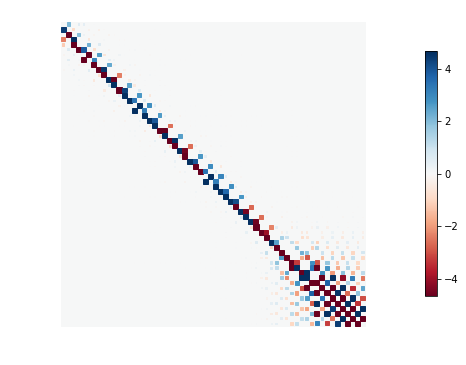

In [17]:
hinton(a_mat.real)

(<matplotlib.figure.Figure at 0x7f3b9338bf28>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f3b924cef98>)

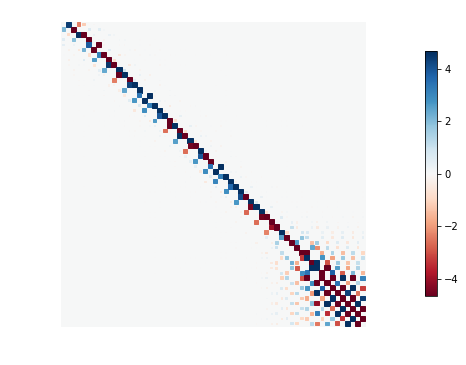

In [18]:
hinton(ad_mat.real)

In [77]:
waq = 3.719645701850315

a   = tensor(destroy(N), qeye(2), qeye(2)) # destroy of cavity
sm  = tensor(qeye(N), destroy(2), qeye(2)) # destroy of qubit
sam = tensor(qeye(N), qeye(2), destroy(2)) # destroy of ancilla
nq  = tensor(qeye(N), sigmaz(), qeye(2)) # number of qubit
nc  = tensor(destroy(N).dag() * destroy(N), qeye(2), qeye(2)) # number of cavity
naq  = tensor(qeye(N), qeye(2), sigmaz()) # number of ancilla

H = 0.5 * (waq ) * naq + 0.5 * wq * nq + wc * nc + g * (a.dag() + a) * (sm + sm.dag()) + gac * (a.dag() + a) * (sam + sam.dag())

ev, ek = H.eigenstates()

In [86]:
E0m = 1/np.sqrt(2) *(tensor(pstate[1], basis(2, 0)) + tensor(pstate[2], basis(2, 1)))

In [87]:
for i in range(7):
    print(i,":", E0m.dag() * ek[i])

0 : Quantum object: dims = [[1], [1]], shape = (1, 1), type = bra
Qobj data =
[[0.02319107]]
1 : Quantum object: dims = [[1], [1]], shape = (1, 1), type = bra
Qobj data =
[[0.]]
2 : Quantum object: dims = [[1], [1]], shape = (1, 1), type = bra
Qobj data =
[[0.]]
3 : Quantum object: dims = [[1], [1]], shape = (1, 1), type = bra
Qobj data =
[[0.99940893]]
4 : Quantum object: dims = [[1], [1]], shape = (1, 1), type = bra
Qobj data =
[[-0.00200245]]
5 : Quantum object: dims = [[1], [1]], shape = (1, 1), type = bra
Qobj data =
[[0.]]
6 : Quantum object: dims = [[1], [1]], shape = (1, 1), type = bra
Qobj data =
[[0.]]
